# MAML

## 0. Paper

### Info
* Title: Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks
* Author: Chelsea Finn
* Task: Meta Learning
* Link: https://arxiv.org/abs/1703.03400


### Features
* Dataset: mini-Imagenet, [link](https://drive.google.com/file/d/1HkgrkAwukzEZA0TpO7010PkAOREb2Nuk/view)
* Dataset: Omniglot, [link](https://github.com/brendenlake/omniglot)

### Reference
* https://github.com/dragen1860/MAML-Pytorch
* https://github.com/tristandeleu/pytorch-meta


## 1. Setting

In [1]:
# Libraries
import os
import sys
import time
from glob import glob
from collections import OrderedDict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import torchsummary

In [2]:
CONFIG = {
    'update_lr': 0.01,
    'update_step': 5,
    'finetune_step': 10,
    'meta_lr': 0.01,
    'n_way': 5,
    'k_shot': 1,
    'k_test': 15,
    'image_size': 28,
    'task_size': 32,
    'epoch_size': 100,
    'base_dir': '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
}

## 2. Data

In [3]:
class MiniImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root, task_size, n_way, k_shot, k_test, transform=None):
        self.task_size = task_size
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_test = k_test
        self.transform = transform

        self.image_dir = os.path.join(root, 'images')
        self.csv = pd.read_csv(os.path.join(root, f'{mode}.csv'))
        self.labels = self.csv['label'].unique()
        self.image2label = self.csv.set_index('filename')['label'].to_dict()
    

    def __len__(self):
        return 100
    
    
    def __getitem__(self, idx):
        train_x, test_x = [], []
        selected_labels = np.random.choice(self.labels, self.n_way, replace=False)

        for label in selected_labels:
            images = self.csv.loc[self.csv['label']==label, 'filename'].sample(self.k_shot + self.k_test).tolist()
            train_x += images[:self.k_shot]
            test_x += images[self.k_shot:]

        np.random.shuffle(train_x)
        np.random.shuffle(test_x)

        train_y = [self.image2label[i] for i in train_x]
        test_y = [self.image2label[i] for i in test_x]
        relative_label = np.unique(train_y)
        np.random.shuffle(relative_label)
        label2idx = {i:idx for idx, i in enumerate(relative_label)}
        train_y = torch.LongTensor([label2idx[i] for i in train_y])
        test_y = torch.LongTensor([label2idx[i] for i in test_y])

        train_x = [os.path.join(self.image_dir, i) for i in train_x]
        test_x = [os.path.join(self.image_dir, i) for i in test_x]
        train_x = torch.stack([self.transform(x) for x in train_x], dim=0)
        test_x = torch.stack([self.transform(x) for x in test_x], dim=0)

        return train_x, train_y, test_x, test_y


class OmniglotDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, task_size, n_way, k_shot, k_test, transform=None):
        self.data = data
        self.labels = labels
        self.task_size = task_size
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_test = k_test
        self.transform = transform
        self.image2label = self.data.set_index('file')['label'].to_dict()


    def __len__(self):
        return 320

    @staticmethod
    def load(root, task_size, n_way, k_shot, k_test, train_transform=None, test_transform=None):
        files = glob(os.path.join(root, '*/*/*/*.png'))
        labels = ['/'.join(i.split('/')[4:6]) for i in files]
        data = pd.DataFrame({'file':files, 'label':labels})

        unique_labels = data['label'].unique()
        random_idx = np.random.permutation(len(unique_labels))
        train_labels = unique_labels[random_idx[:1200]]
        test_labels = unique_labels[random_idx[1200:]]

        return OmniglotDataset(data, train_labels, task_size, n_way, k_shot, k_test, train_transform), OmniglotDataset(data, test_labels, task_size, n_way, k_shot, k_test, test_transform)

    def __getitem__(self, idx):
        train_x, test_x = [], []
        selected_labels = np.random.choice(self.labels, self.n_way, replace=False)

        for label in selected_labels:
            images = self.data.loc[self.data['label']==label, 'file'].sample(self.k_shot + self.k_test).tolist()
            train_x += images[:self.k_shot]
            test_x += images[self.k_shot:]

        np.random.shuffle(train_x)
        np.random.shuffle(test_x)

        train_y = [self.image2label[i] for i in train_x]
        test_y = [self.image2label[i] for i in test_x]
        relative_label = np.unique(train_y)
        np.random.shuffle(relative_label)
        label2idx = {i:idx for idx, i in enumerate(relative_label)}
        train_y = torch.LongTensor([label2idx[i] for i in train_y])
        test_y = torch.LongTensor([label2idx[i] for i in test_y])

        train_x = torch.stack([self.transform(x) for x in train_x], dim=0)
        test_x = torch.stack([self.transform(x) for x in test_x], dim=0)

        return train_x, train_y, test_x, test_y

In [6]:
# data_path = os.path.join(CONFIG['base_dir'], 'data/mini_imagenet.zip')
data_path = os.path.join(CONFIG['base_dir'], 'data/omniglot.zip')
!unzip -q "{data_path}" -d 'data'

In [4]:
train_transform = transforms.Compose([
    lambda x : Image.open(x).convert('L'),
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    lambda x : Image.open(x).convert('L'),
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
])

In [5]:
train_data, test_data = OmniglotDataset.load('/content/data', CONFIG['task_size'], CONFIG['n_way'], CONFIG['k_shot'], CONFIG['k_test'], train_transform, test_transform)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, CONFIG['task_size'], shuffle=True, pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, CONFIG['task_size'], shuffle=True, pin_memory=True, drop_last=True)

In [7]:
train_x, train_y, test_x, test_y = next(iter(train_loader))
train_x.size(), train_y.size(), test_x.size(), test_y.size()

(torch.Size([32, 5, 1, 28, 28]),
 torch.Size([32, 5]),
 torch.Size([32, 75, 1, 28, 28]),
 torch.Size([32, 75]))

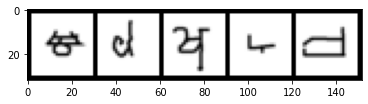

In [8]:
plt.imshow(torchvision.utils.make_grid(train_x[0], nrow=5).permute(1, 2, 0))
plt.show()

## 3. Model

In [9]:
class MetaLinear(nn.Linear):
    def forward(self, x, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())
        bias = params.get('bias', None)
        return F.linear(x, params['weight'], bias)


class MetaConv2d(nn.Conv2d):
    def forward(self, x, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())
        bias = params.get('bias', None)
        return F.conv2d(x, params['weight'], bias, self.stride, self.padding, self.dilation, self.groups)


class MetaBatchNorm2d(nn.modules.BatchNorm2d):
    def forward(self, x, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())
        
        if self.momentum is None:
            exponential_average_factor = 0.0
        else:
            exponential_average_factor = self.momentum
        
        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum
        
        weight = params.get('weight', None)
        bias = params.get('bias', None)
        training = self.training or not self.track_running_stats
        return F.batch_norm(x, self.running_mean, self.running_var, weight, bias, training, exponential_average_factor, self.eps)

In [10]:
class Network(nn.Module):
    def __init__(self, n_way):
        super(Network, self).__init__()
        self.layers = {
            'meta_conv1': MetaConv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            'meta_bn1': MetaBatchNorm2d(64),
            'relu1': nn.ReLU(),
            'pool1': nn.MaxPool2d(2),
            'meta_conv2': MetaConv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            'meta_bn2': MetaBatchNorm2d(64),
            'relu2': nn.ReLU(),
            'pool2': nn.MaxPool2d(2),
            'meta_conv3': MetaConv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            'meta_bn3': MetaBatchNorm2d(64),
            'relu3': nn.ReLU(),
            'pool3': nn.MaxPool2d(2),
            'meta_conv4': MetaConv2d(64, 64, kernel_size=2, stride=1, padding=0, bias=False),
            'meta_bn4': MetaBatchNorm2d(64),
            'relu4': nn.ReLU(),
            'pool4': nn.MaxPool2d(2),
            'flatten': nn.Flatten(),
            'meta_linear': MetaLinear(64, n_way)
        }
        self.layers = nn.ModuleDict(self.layers)
    
    def get_named_params(self):
        return OrderedDict(self.named_parameters())
    
    def forward(self, x, params={}):
        for layer_name, layer in self.layers.items():
            if 'meta' in layer_name:
                p = {k.split('.')[-1]:v for k,v in params.items() if layer_name in k} if params else None
                x = layer(x, params=p)
            else:
                x = layer(x)
        return x

## 4. Experiment

In [11]:
class AverageMeter(object):
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = f'{self.name:10s} {self.avg:.3f}'
        return fmtstr


class ProgressMeter(object):
    def __init__(self, meters, loader_length, prefix=""):
        self.meters = [AverageMeter(i) for i in meters]
        self.loader_length = loader_length
        self.prefix = prefix
    
    def reset(self):
        for m in self.meters:
            m.reset()
    
    def update(self, values, n=1):
        for m, v in zip(self.meters, values):
            m.update(v, n)
            self.__setattr__(m.name, m.avg)

    def display(self, batch_idx, postfix=""):
        batch_info = f'[{batch_idx+1:03d}/{self.loader_length:03d}]'
        msg = [self.prefix + ' ' + batch_info]
        msg += [str(meter) for meter in self.meters]
        msg = ' | '.join(msg)

        sys.stdout.write('\r')
        sys.stdout.write(msg + postfix)
        sys.stdout.flush()


def accuracy(logits, targets):
    _, pred = logits.max(1)
    acc = pred.eq(targets).float().mean().item()
    return acc

In [12]:
class Trainer(object):
    def __init__(self, model, criterion, optimizer, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
    
    def train(self, train_loader, epoch):
        progress = ProgressMeter(["train_loss", "train_acc"], len(train_loader), prefix=f'EPOCH {epoch:03d}')
        self.model.train()
        start_time = time.time()

        for idx, (train_x, train_y, test_x, test_y) in enumerate(train_loader):
            train_x, train_y, test_x, test_y = train_x.to(self.device), train_y.to(self.device), test_x.to(self.device), test_y.to(self.device)

            meta_loss = torch.tensor(0.).to(device)
            meta_acc = torch.tensor(0.).to(device)

            for i in range(CONFIG['task_size']):
                fast_params = self.model.get_named_params()

                for j in range(CONFIG['update_step']):
                    logits = self.model(train_x[i], fast_params)
                    loss = self.criterion(logits, train_y[i])
                    grads = torch.autograd.grad(loss, fast_params.values())
                    fast_params = OrderedDict({n:p - CONFIG['update_lr'] * g for (n, p), g in zip(fast_params.items(), grads)})
                
                test_logits = self.model(test_x[i], fast_params)
                test_loss = criterion(test_logits, test_y[i])
                meta_loss += test_loss
                _, pred = test_logits.max(1)
                acc = pred.eq(test_y[i]).float().mean()
                meta_acc += acc

            meta_loss.div_(CONFIG['task_size'])
            meta_acc.div_(CONFIG['task_size'])

            self.optimizer.zero_grad()
            meta_loss.backward()
            self.optimizer.step()

            progress.update([meta_loss.item(), meta_acc.item()], n=CONFIG['task_size'])
            if idx % 10 == 0:
                progress.display(idx)

        finish_time = time.time()
        epoch_time = finish_time - start_time
        progress.display(idx, f' | {epoch_time:.0f}s' + '\n')

    
    def test(self, test_loader, prefix):
        progress = ProgressMeter(["test loss", "test acc"], len(test_loader), prefix=prefix)
        self.model.train()
        start_time = time.time()

        for idx, (train_x, train_y, test_x, test_y) in enumerate(test_loader):
            train_x, train_y, test_x, test_y = train_x.to(self.device), train_y.to(self.device), test_x.to(self.device), test_y.to(self.device)

            meta_loss = torch.tensor(0.).to(device)
            meta_acc = torch.tensor(0.).to(device)

            for i in range(CONFIG['task_size']):
                fast_params = self.model.get_named_params()

                for j in range(CONFIG['finetune_step']):
                    logits = self.model(train_x[i], fast_params)
                    loss = self.criterion(logits, train_y[i])
                    grads = torch.autograd.grad(loss, fast_params.values())
                    fast_params = OrderedDict({n:p - CONFIG['update_lr'] * g for (n, p), g in zip(fast_params.items(), grads)})

                test_logits = self.model(test_x[i], fast_params)
                test_loss = criterion(test_logits, test_y[i])
                meta_loss += test_loss

                _, pred = test_logits.max(1)
                acc = pred.eq(test_y[i]).float().mean()
                meta_acc += acc

            meta_loss.div_(CONFIG['task_size'])
            meta_acc.div_(CONFIG['task_size'])

            progress.update([meta_loss.item(), meta_acc.item()], n=CONFIG['task_size'])
            if idx % 10 == 0:
                progress.display(idx)

        finish_time = time.time()
        epoch_time = finish_time - start_time
        progress.display(idx, f' | {epoch_time:.0f}s' + '\n')

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(CONFIG['n_way']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['meta_lr'])

In [14]:
trainer = Trainer(model, criterion, optimizer, device)

In [15]:
for ep in range(CONFIG['epoch_size']):
    print('=' * 65)
    trainer.train(train_loader, ep)
    if ep % 5 == 0:
        trainer.test(test_loader, prefix=f'TEST  {ep:03d}')

EPOCH 000 [010/010] | train_loss 1.315 | train_acc  0.493 | 14s
TEST  000 [010/010] | test loss  1.160 | test acc   0.623 | 17s
EPOCH 001 [010/010] | train_loss 1.234 | train_acc  0.561 | 14s
EPOCH 002 [010/010] | train_loss 1.132 | train_acc  0.602 | 14s
EPOCH 003 [010/010] | train_loss 1.091 | train_acc  0.618 | 14s
EPOCH 004 [010/010] | train_loss 1.062 | train_acc  0.610 | 14s
EPOCH 005 [010/010] | train_loss 0.970 | train_acc  0.656 | 14s
TEST  005 [010/010] | test loss  0.855 | test acc   0.699 | 17s
EPOCH 006 [010/010] | train_loss 0.813 | train_acc  0.718 | 14s
EPOCH 007 [010/010] | train_loss 0.708 | train_acc  0.754 | 14s
EPOCH 008 [010/010] | train_loss 0.659 | train_acc  0.771 | 14s
EPOCH 009 [010/010] | train_loss 0.603 | train_acc  0.785 | 14s
EPOCH 010 [010/010] | train_loss 0.522 | train_acc  0.817 | 14s
TEST  010 [010/010] | test loss  0.520 | test acc   0.814 | 17s
EPOCH 011 [010/010] | train_loss 0.482 | train_acc  0.831 | 14s
EPOCH 012 [010/010] | train_loss 0.458 |

In [16]:
trainer.test(test_loader, prefix='TEST')

TEST [010/010] | test loss  0.254 | test acc   0.914 | 17s
